In [2]:
# import dependencies

import re
import os
import csv
import pandas as pd
from dotenv import load_dotenv
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
import seaborn as sns

# uncomment below if running locally and wordcloud exists in your environment
# from wordcloud import WordCloud 

%matplotlib inline

### Process 2020 Social Media Post Data

In [3]:
# Define the file path
file_path = "../Source_data/posts_2020.csv"

# Initialize an empty DataFrame to hold the filtered data
posts_2020_df = pd.DataFrame()

# Define the acceptable values for the 'country' column
acceptable_countries = ["United States", "United States of America"]

# Process the file in chunks to handle large files
chunk_size = 10**6  # Adjust the chunk size based on your system's memory capacity
for chunk in pd.read_csv(
    file_path,
    engine='python',                  # Use Python engine to handle more complex cases
    on_bad_lines='skip',              # Skip problematic lines
    delimiter=',',                    # Ensure correct delimiter
    chunksize=chunk_size              # Read the file in chunks
):
    # Filter rows based on the 'country' column
    filtered_chunk = chunk[chunk['country'].isin(acceptable_countries)]
    # Append the filtered chunk to the main DataFrame
    posts_2020_df = pd.concat([posts_2020_df, filtered_chunk], ignore_index=True)

# Verify the result
posts_2020_df.head()

created_at                tweet_id  \
0  2020-10-15 00:00:01   1.316529221557252e+18   
1  2020-10-15 00:00:02   1.316529228091847e+18   
2  2020-10-15 00:00:08  1.3165292523014513e+18   
3  2020-10-15 00:00:17   1.316529291052675e+18   
4  2020-10-15 00:00:18  1.3165292934979625e+18   

                                               tweet likes  retweet_count  \
0  #Elecciones2020 | En #Florida: #JoeBiden dice ...   0.0            0.0   
1  #Trump: As a student I used to hear for years,...   2.0            1.0   
2  You get a tie! And you get a tie! #Trump ‘s ra...   4.0            3.0   
3  @CLady62 Her 15 minutes were over long time ag...   2.0            0.0   
4  @DeeviousDenise @realDonaldTrump @nypost There...   0.0            0.0   

                source                user_id  \
0            TweetDeck            360666534.0   
1      Twitter Web App              8436472.0   
2   Twitter for iPhone             47413798.0   
3  Twitter for Android           1138416104.0   
4   Twitter for iPhone  9.007610716314296e+17   

                                    user_name user_screen_name  \
0                          El Sol Latino News  elsollatinonews   
1                                      snarke           snarke   
2                       Rana Abtar - رنا أبتر        Ranaabtar   
3                                Farris Flagg      FarrisFlagg   
4  Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️      sm_gulledge   

                                    user_description  ...  \
0  🌐 Noticias de interés para latinos de la costa...  ...   
1  Will mock for food! Freelance writer, blogger,...  ...   
2  Washington Correspondent, Lebanese-American ,c...  ...   
3  #BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...  ...   
4  Patriot, Wife, “Shaken not Stirred” Mom of two...  ...   

  user_followers_count                 user_location                 lat  \
0               1860.0  Philadelphia, PA / Miami, FL            25.77427   
1               1185.0                      Portland          45.5202471   
2               5393.0                 Washington DC          38.8949924   
3               2363.0             Perris,California          33.7825194   
4                766.0                     Ohio, USA  40.225356899999994   

                  long        city                   country      continent  \
0            -80.19366         NaN  United States of America  North America   
1         -122.6741949    Portland  United States of America  North America   
2          -77.0365581  Washington  United States of America  North America   
3  -117.22864779999999         NaN  United States of America  North America   
4          -82.6881395         NaN  United States of America  North America   

                  state state_code                   collected_at  
0               Florida         FL            2020-10-21 00:00:00  
1                Oregon         OR  2020-10-21 00:00:00.746433060  
2  District of Columbia         DC  2020-10-21 00:00:01.492866121  
3            California         CA  2020-10-21 00:00:01.866082651  
4                  Ohio         OH  2020-10-21 00:00:02.612515712  

[5 rows x 21 columns]

In [4]:
# Restrict dataframe to columns of interest

# Rename columns
posts_2020_df.rename(columns={
    'user_screen_name': 'handle',
    'tweet': 'text',
    'created_at': 'time',
    'tweet_id': 'id'
}, inplace=True)

# Select only the required columns
posts_2020_df = posts_2020_df[['id', 'handle', 'text', 'time']]

# Verify the result
posts_2020_df.head()

id           handle  \
0   1.316529221557252e+18  elsollatinonews   
1   1.316529228091847e+18           snarke   
2  1.3165292523014513e+18        Ranaabtar   
3   1.316529291052675e+18      FarrisFlagg   
4  1.3165292934979625e+18      sm_gulledge   

                                                text                 time  
0  #Elecciones2020 | En #Florida: #JoeBiden dice ...  2020-10-15 00:00:01  
1  #Trump: As a student I used to hear for years,...  2020-10-15 00:00:02  
2  You get a tie! And you get a tie! #Trump ‘s ra...  2020-10-15 00:00:08  
3  @CLady62 Her 15 minutes were over long time ag...  2020-10-15 00:00:17  
4  @DeeviousDenise @realDonaldTrump @nypost There...  2020-10-15 00:00:18

In [6]:
sentiments20 = []

for comment in posts_2020_df['text']:
    try:
        # Directly use the comment since it's already a string
        text = comment
        results = analyzer.polarity_scores(text)
        compound = results['compound']
        pos = results['pos']
        neu = results['neu']
        neg = results['neg']
        
        sentiments20.append({
            'Compound': compound,
            'Positive': pos,
            'Negative': neg,
            'Neutral': neu,
            'text': text,
        })
    except AttributeError:
        pass
    
sm20 = pd.DataFrame(sentiments20)
sm20.head()

Compound  Positive  Negative  Neutral  \
0    0.0000     0.000     0.000    1.000   
1    0.5905     0.071     0.000    0.929   
2    0.0000     0.000     0.000    1.000   
3   -0.4912     0.000     0.126    0.874   
4   -0.2617     0.056     0.078    0.866   

                                                text  
0  #Elecciones2020 | En #Florida: #JoeBiden dice ...  
1  #Trump: As a student I used to hear for years,...  
2  You get a tie! And you get a tie! #Trump ‘s ra...  
3  @CLady62 Her 15 minutes were over long time ag...  
4  @DeeviousDenise @realDonaldTrump @nypost There...

In [7]:
#summary statistics sm20
sm20.describe()

Compound       Positive       Negative        Neutral
count  213259.000000  213259.000000  213259.000000  213259.000000
mean       -0.009011       0.080170       0.080945       0.838883
std         0.476845       0.105996       0.110512       0.145215
min        -0.999500       0.000000       0.000000       0.012000
25%        -0.361200       0.000000       0.000000       0.741000
50%         0.000000       0.024000       0.000000       0.848000
75%         0.361200       0.138000       0.141000       1.000000
max         0.998700       0.958000       0.988000       1.000000

In [ ]:
import gc

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def process_text_2020(text):
    tokens = word_tokenize(text.lower())
    token_sentiments = {}
    
    for token in tokens:
        if token.isalpha():  # Consider only alphabetic tokens
            sentiment = analyzer.polarity_scores(token)
            token_sentiments[token] = sentiment['compound']
    
    return token_sentiments

# Define a function to process chunks of data
def process_chunk(chunk):
    chunk = chunk.copy()  # Make a copy of the chunk to avoid SettingWithCopyWarning
    chunk['token_sentiments_2020'] = chunk['text'].apply(process_text_2020)
    tokens_df = pd.json_normalize(chunk['token_sentiments_2020'])
    tokens_df.columns = [f'token_{col}' for col in tokens_df.columns]
    return chunk.drop(columns=['token_sentiments_2020']).join(tokens_df)

# Process data in chunks
chunk_size = 10000  # Adjust chunk size based on available memory

# Create a generator for processing chunks
def chunk_generator(df, chunk_size):
    for start in range(0, len(df), chunk_size):
        yield df.iloc[start:start + chunk_size].copy()  # Ensure each chunk is a copy

# Process each chunk and concatenate results
processed_chunks = [process_chunk(chunk) for chunk in chunk_generator(sm20, chunk_size)]
sm20_processed = pd.concat(processed_chunks, ignore_index=True)

# Clean up memory
del processed_chunks
gc.collect()

In [8]:
# # Tokenize the text and calculate sentiment for each token
# def get_token_sentiments_2020(text):
#     tokens20 = word_tokenize(text.lower())  # Tokenize and convert to lower case
#     token_sentiments_2020 = {}
    
#     for token in tokens20:
#         if token.isalpha():  # Consider only alphabetic tokens
#             # Analyze sentiment for each token in the context of the whole text
#             sentiment_2020 = analyzer.polarity_scores(token)
#             token_sentiments_2020[token] = sentiment_2020['compound']
    
#     return token_sentiments_2020

In [9]:
# # Apply the function to each row and expand the results into a DataFrame
# def process_text_2020(text):
#     token_sentiments_2020 = get_token_sentiments_2020(text)
#     return token_sentiments_2020

In [10]:
# # Apply the function to the 'text' column
# sm20['token_sentiments_2020'] = sm20['text'].apply(process_text_2020)

# # Expand token sentiments into separate columns
# tokens_2020_df = pd.json_normalize(sm20['token_sentiments_2020'])

# # Rename columns in tokens_df to avoid overlap with original sm16 columns
# tokens_2020_df.columns = [f'token_{col}' for col in tokens_2020_df.columns]

# sm20 = sm20.drop(columns=['token_sentiments_2020']).join(tokens_2020_df)

# # Analyze and visualize token sentiment
# sm20.head()

MemoryError: Unable to allocate 197. GiB for an array with shape (213259, 123987) and data type object

In [9]:
# Average sentiment score per token
average_sentiments_2016 = tokens_2016_df.mean().sort_values(ascending=False)
print("Average sentiment scores per token:")
print(average_sentiments_2016)

Average sentiment scores per token:
token_magnificently    0.6597
token_sweetheart       0.6486
token_glorious         0.6369
token_greatest         0.6369
token_best             0.6369
                        ...  
token_hell            -0.6808
token_terrorist       -0.6908
token_kill            -0.6908
token_murder          -0.6908
token_rapist          -0.7096
Length: 8496, dtype: float64


In [10]:
# Define a function to determine the candidate based on the handle
def determine_candidate_from_handle(handle):
    handle = handle.lower()  # Convert handle to lower case for case-insensitive comparison
    
    # Define patterns for combined keywords
    democrat_keywords = ['hillaryclinton']
    republican_keywords = ['realdonaldtrump']
    
    # Check if any of the Democrat patterns are present in the handle
    if any(keyword in handle for keyword in democrat_keywords):
        return 'Democrat'
    
    # Check if any of the Republican patterns are present in the handle
    elif any(keyword in handle for keyword in republican_keywords):
        return 'Republican'
    
    # Return 'Unknown' if no patterns are matched
    else:
        return 'Unknown'

In [11]:
# Apply the function to the 'handle' column to create/update the 'candidate' column
posts_2016_df['candidate'] = posts_2016_df['handle'].apply(determine_candidate_from_handle)

# Verify the result
posts_2016_df.head()

id          handle  \
0  780925634159796224  HillaryClinton   
1  780916180899037184  HillaryClinton   
2  780911564857761793  HillaryClinton   
3  780907038650068994  HillaryClinton   
4  780897419462602752  HillaryClinton   

                                                text                 time  \
0  The question in this election: Who can put the...  2016-09-28T00:22:34   
1  Last night, Donald Trump said not paying taxes...  2016-09-27T23:45:00   
2  Couldn't be more proud of @HillaryClinton. Her...  2016-09-27T23:26:40   
3  If we stand together, there's nothing we can't...  2016-09-27T23:08:41   
4  Both candidates were asked about how they'd co...  2016-09-27T22:30:27   

  candidate  
0  Democrat  
1  Democrat  
2  Democrat  
3  Democrat  
4  Democrat

In [12]:
# Count the number of 'Unknown' entries in the 'candidate' column
unknown_count = posts_2016_df['candidate'].value_counts().get('Unknown', 0)

print(f"Number of 'Unknown' entries: {unknown_count}")

Number of 'Unknown' entries: 0


In [13]:
# Merge sm16 with posts_2016_df on the 'text' column to add 'candidate'
sm16_with_candidates = pd.merge(sm16, posts_2016_df[['text', 'candidate']], on='text', how='left')

# View dataframe
sm16_with_candidates.head()

Compound  Positive  Negative  Neutral  \
0    0.4404     0.139     0.000    0.861   
1    0.0000     0.000     0.000    1.000   
2    0.1850     0.165     0.102    0.733   
3    0.1376     0.128     0.101    0.771   
4   -0.6597     0.000     0.278    0.722   

                                                text  token_the  \
0  The question in this election: Who can put the...        0.0   
1  Last night, Donald Trump said not paying taxes...        NaN   
2  Couldn't be more proud of @HillaryClinton. Her...        NaN   
3  If we stand together, there's nothing we can't...        NaN   
4  Both candidates were asked about how they'd co...        NaN   

   token_question  token_in  token_this  token_election  ...  \
0             0.0       0.0         0.0             0.0  ...   
1             NaN       NaN         NaN             NaN  ...   
2             NaN       NaN         NaN             NaN  ...   
3             NaN       NaN         NaN             NaN  ...   
4             NaN       NaN         NaN             NaN  ...   

   token_illustrates  token_duh  token_lilredfrmkokomo  token_lowell  \
0                NaN        NaN                    NaN           NaN   
1                NaN        NaN                    NaN           NaN   
2                NaN        NaN                    NaN           NaN   
3                NaN        NaN                    NaN           NaN   
4                NaN        NaN                    NaN           NaN   

   token_iloveidevices  token_minimizing  token_dependency  \
0                  NaN               NaN               NaN   
1                  NaN               NaN               NaN   
2                  NaN               NaN               NaN   
3                  NaN               NaN               NaN   
4                  NaN               NaN               NaN   

   token_salriccobono  token_troyconway  candidate  
0                 NaN               NaN   Democrat  
1                 NaN               NaN   Democrat  
2                 NaN               NaN   Democrat  
3                 NaN               NaN   Democrat  
4                 NaN               NaN   Democrat  

[5 rows x 8502 columns]

In [17]:
# Identify all token columns
token_columns = [col for col in sm16_with_candidates.columns if col.startswith('token_')]

# Ensure that the value name does not match any existing column names
# Checking for potential conflicts
existing_columns = set(sm16_with_candidates.columns)
unique_value_name = 'token_count' if 'token_count' not in existing_columns else 'token_count_unique'

# Reshape the DataFrame from wide to long format for tokens
tokens_long_df = sm16_with_candidates.melt(
    id_vars=['text', 'candidate'], 
    value_vars=token_columns,
    var_name='token',
    value_name=unique_value_name
)

# Filter out rows where token_count is 0
tokens_long_df = tokens_long_df[tokens_long_df[unique_value_name] > 0]

# Melt sentiment columns to long format
sentiment_columns = ['Compound', 'Positive', 'Negative', 'Neutral']
sentiments_long_df = sm16_with_candidates.melt(
    id_vars=['text', 'candidate'],
    value_vars=sentiment_columns,
    var_name='sentiment_type',
    value_name='sentiment_value'
)

# Merge token presence with sentiment values on 'text' and 'candidate'
merged_df = tokens_long_df.merge(sentiments_long_df, on=['text', 'candidate'])

# Aggregate sentiment values by candidate and token
token_sentiments_2016 = merged_df.groupby(['candidate', 'token']).agg({
    'sentiment_value': 'mean',
    unique_value_name: 'sum'
}).reset_index()

# Verify the result
token_sentiments_2016.head()

candidate            token  sentiment_value  token_count_unique
0  Democrat    token_ability         0.321694              5.0912
1  Democrat     token_accept         0.376663             15.2720
2  Democrat   token_accepted         0.303513              4.3712
3  Democrat  token_accepting         0.176000              1.5272
4  Democrat    token_accepts         0.355375              2.5456

In [18]:
# Aggregate sentiment scores by candidate

# Calculate weighted average sentiment score for each candidate
# This step uses the 'sentiment_value' and 'token_count_unique' columns
candidate_sentiments = token_sentiments_2016.groupby('candidate').apply(
    lambda df: (df['sentiment_value'] * df['token_count_unique']).sum() / df['token_count_unique'].sum()
).reset_index(name='average_sentiment')

# Display the aggregated sentiment scores
print("Average sentiment scores by candidate:")
print(candidate_sentiments)

Average sentiment scores by candidate:
    candidate  average_sentiment
0    Democrat           0.364082
1  Republican           0.403678


In [19]:
# Combine sentiment scores with other features

# Merge candidate sentiments with posts_2016_df
# Make sure to use the 'candidate' column for merging
sent_2016_df = pd.merge(posts_2016_df, candidate_sentiments, on='candidate', how='left')

# Display the final DataFrame with the required columns
sent_2016_df = sent_2016_df[['id', 'text', 'time', 'candidate', 'average_sentiment']]
sent_2016_df.head()

id                                               text  \
0  780925634159796224  The question in this election: Who can put the...   
1  780916180899037184  Last night, Donald Trump said not paying taxes...   
2  780911564857761793  Couldn't be more proud of @HillaryClinton. Her...   
3  780907038650068994  If we stand together, there's nothing we can't...   
4  780897419462602752  Both candidates were asked about how they'd co...   

                  time candidate  average_sentiment  
0  2016-09-28T00:22:34  Democrat           0.364082  
1  2016-09-27T23:45:00  Democrat           0.364082  
2  2016-09-27T23:26:40  Democrat           0.364082  
3  2016-09-27T23:08:41  Democrat           0.364082  
4  2016-09-27T22:30:27  Democrat           0.364082

In [20]:
# Edit the time column to display only the year

# Ensure the 'time' column is in datetime format
sent_2016_df['time'] = pd.to_datetime(sent_2016_df['time'], errors='coerce')

# Extract the year from the datetime column and update the 'time' column
sent_2016_df['time'] = sent_2016_df['time'].dt.year

# Display the modified DataFrame
sent_2016_df.head()

id                                               text  \
0  780925634159796224  The question in this election: Who can put the...   
1  780916180899037184  Last night, Donald Trump said not paying taxes...   
2  780911564857761793  Couldn't be more proud of @HillaryClinton. Her...   
3  780907038650068994  If we stand together, there's nothing we can't...   
4  780897419462602752  Both candidates were asked about how they'd co...   

   time candidate  average_sentiment  
0  2016  Democrat           0.364082  
1  2016  Democrat           0.364082  
2  2016  Democrat           0.364082  
3  2016  Democrat           0.364082  
4  2016  Democrat           0.364082

In [21]:
# Save the final 2016 DataFrame to a CSV file
sent_2016_df.to_csv('../CSV_Outputs/sent_2016_df.csv', index=False)

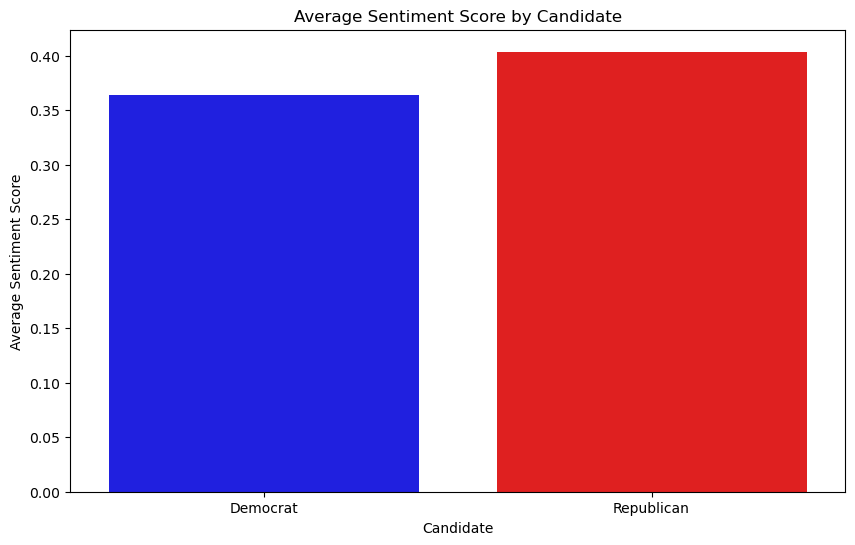

In [22]:
# Plot average sentiment scores for each candidate

# Define color palette to match the colleague's visual
color_palette = {'Democrat': 'blue', 'Republican': 'red'}

# Create a seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='candidate', y='average_sentiment', data=candidate_sentiments, palette=color_palette)

# Add labels and title
plt.xlabel('Candidate')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Candidate')

# Show the plot
plt.show()

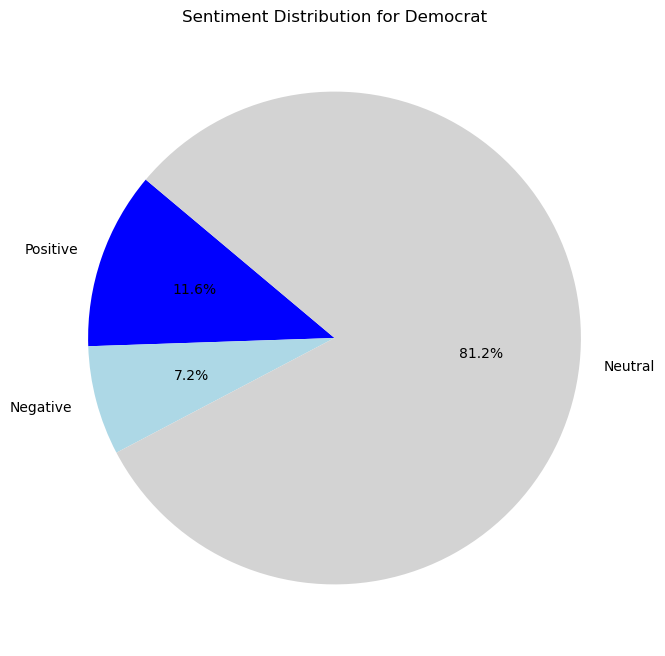

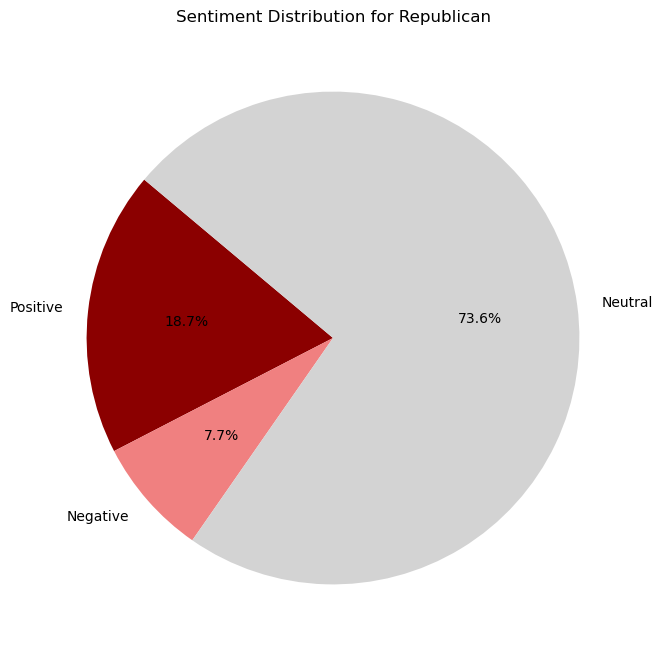

In [29]:
# Display positive, negative, and neutral sentiment scores by candidate

# Aggregate sentiment scores by candidate
sentiment_summary = sm16_with_candidates.groupby('candidate')[['Positive', 'Negative', 'Neutral']].sum().reset_index()

# Define color palette for sentiments
color_palettes = {
    'Democrat': {
        'Positive': 'blue',  # Replace 'strongblue' with actual color code
        'Negative': 'lightblue',   # Replace 'palerblue' with actual color code
        'Neutral': 'lightgrey'
    },
    'Republican': {
        'Positive': 'darkred',     # Strong red
        'Negative': 'lightcoral',  # Pale red
        'Neutral': 'lightgrey'
    }
}

# Define a function to plot a pie chart for a given candidate
def plot_pie_chart(candidate, positive, negative, neutral):
    sentiments = [positive, negative, neutral]
    labels = ['Positive', 'Negative', 'Neutral']
    colors = color_palettes.get(candidate, {
        'Positive': 'grey',
        'Negative': 'grey',
        'Neutral': 'grey'
    }).values()
    
    plt.figure(figsize=(8, 8))
    plt.pie(sentiments, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'Sentiment Distribution for {candidate}')
    plt.show()

# Plot pie charts for each candidate
for index, row in sentiment_summary.iterrows():
    candidate = row['candidate']
    positive = row['Positive']
    negative = row['Negative']
    neutral = row['Neutral']
    plot_pie_chart(candidate, positive, negative, neutral)


In [ ]:
# Generate a Word Cloud by candidate (uncomment below if running in CoLab)

# !pip install wordcloud
# from wordcloud import WordCloud

In [ ]:
# Aggregate token counts by candidate
token_frequencies = token_sentiments_2016.groupby('candidate')['token_count'].sum().reset_index()

# Define a function to generate and display a word cloud for a given candidate
def generate_word_cloud(candidate, token_counts):
    # Create a dictionary of token frequencies
    token_freq_dict = dict(zip(token_counts['token'], token_counts['token_count']))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(token_freq_dict)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # No axes for word cloud
    plt.title(f'Word Cloud for {candidate}')
    plt.show()

# Generate word clouds for each candidate
candidates = token_sentiments_2016['candidate'].unique()
for candidate in candidates:
    # Filter token counts for the current candidate
    candidate_tokens = token_sentiments_2016[token_sentiments_2016['candidate'] == candidate]
    
    # Generate and display word cloud
    generate_word_cloud(candidate, candidate_tokens)